In [163]:
import sys
sys.path.append("/Users/Tanay/Desktop/CS269I/StableCoinSimulator/PyLOB/")

import math
from random import randint
from numpy.random import normal
from collections import defaultdict, OrderedDict
from PyLOB import OrderBook
import matplotlib.pyplot as plt
import numpy as np
from queue import Queue
# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
def biased_coin(prob):
    return int(np.random.random() < prob)

In [98]:
def clamp_bas_price(price):
    # 1 BAS = price ETH
    return np.clip(price, 0, 10.0)

def clamp_bas_qty(qty): 
    # Max order size of $100,000
    return np.clip(qty, 0, 1e5)

def months_to_seconds(mths):
    return mths * 30 * 24 * 60 * 60

In [162]:
class BasisBond: 
    def __init__(self, tid, timestamp, expiry):
        self.tid = tid
        self.timestamp = int(timestamp)
        self.expirytime = self.timestamp + expiry


In [99]:
class Protocol:
    def __init__(self, totalSupply):
        self.totalSupply = totalSupply
        self.market = None
        
    def update(self):
        pass
        
class BasisProtocol(Protocol):
    
    def __init__(self, totalSupply, market):
        super().__init__(totalSupply)
        self.market = market
        self.bond_expiry = months_to_seconds(60) # 5 year expiry
        self.bondsForAuction = 0
        self.bondQueue = Queue()
        
    def update(self):
        price = market.getCurrentUSDValue()
        
        LOWER = 0.99
        UPPER = 1.01
        
        # Value of Supply = Market Cap
        # Market Cap is constant, PRICE * QTY = PRICE' * QTY'
        # QTY' = (PRICE / PRICE') * QTY
        #        (0.9 / 1.0) * 1M 
        # delQTY = deviation (0.1) * supply (1M)
        
        # ISSUE bonds
        if price < LOWER:
            newSupply = price * self.totalSupply
            bondsToCreate = self.totalSupply - newSupply 
            bondsForAuction += bondsToCreate
            
        elif price > UPPER:
            # PUMP money into the system and payoff bonds
            pass
    

In [140]:
class Trader: 
    def __init__(self, tid, protocol, market):
        self.tid = tid
        self.protocol = protocol
        self.market = market
        self.portfolioRatio = 0.5
        self.eth = 10
        self.bas = 1000
        
    def getIdealValue(self):
        return self.eth * 100 + self.bas

    def marketStep(self):
        return None
    
'''
    IdealTrader buys/sells according to market demand. 
    Sets prices to be around the ideal exchange rate ~ 0.01.
'''
class IdealTrader(Trader):
    def __init__(self, tid, protocol, market):
        super().__init__(tid, protocol, market)
        self.bas = 100000 # $100,000 in BASIS 
        self.portfolioRatio = 0.01
        
    def marketStep(self):
        BASE_PRICE = self.market.usd_eth # Assuming 1 ETH = $100
        BASE_SPREAD = 1e-3 # 0.10% spread

        # Randomly select bid / ask based on market demand
        side = ['bid', 'ask'][biased_coin(self.market.demandRatio)]
        
        # Set price around BASE_PRICE
        price = normal(BASE_PRICE, 0.0002)
        if side == 'bid':
            price -= (BASE_PRICE * BASE_SPREAD) 
        else:
            price += (BASE_PRICE * BASE_SPREAD) 
        price = clamp_bas_price(price)
        
        # Set Quantity around portfolio ratio 
        qty_mu = self.portfolioRatio
        qty_sigma = qty_mu * 0.1
        qty = int(normal(qty_mu, qty_sigma) * self.bas)
        qty = clamp_bas_qty(qty)

        if qty <= 0:
            return None
        
        order = {'type': 'limit', 'price': price, 'tid': self.tid, 'side': side, 'qty': qty}
        return order
    
class RandomTrader(Trader): 
    def __init__(self, key, protocol, market):
        super().__init__(key, protocol, market)
        self.portfolioRatio = 0.05
        self.bas = 10000
        
    def marketStep(self):
        BASE_PRICE = self.market.getCurrentETHValue() # Assuming 1 ETH = $100
        BASE_SPREAD = 1e-3 # 0.10% spread

        # Randomly select bid / ask based on market demand
        side = ['bid', 'ask'][biased_coin(self.market.demandRatio)]
        
        # Set price around BASE_PRICE
        price = normal(BASE_PRICE, 0.0001)
        if side == 'bid':
            price -= (BASE_PRICE * BASE_SPREAD) 
        else:
            price += (BASE_PRICE * BASE_SPREAD) 
        price = clamp_bas_price(price)

        # Set Quantity around portfolio ratio 
        qty_mu = self.portfolioRatio
        qty_sigma = qty_mu * 0.1
        qty = normal(qty_mu, qty_sigma) * self.bas
        qty = clamp_bas_qty(qty)

        if qty <= 0:
            return None
        
        
        
        
        order = {'type': 'limit', 'price': price, 'tid': self.tid, 'side': side, 'qty': qty}
        return order

class TrendMaker(Trader):
    pass

class BuyFDeeps(Trader):
    pass

class BasicTrader(Trader): 
    pass

class OracleSpeculator(Trader): 
    pass

class ArbitrageUpTrader(Trader):
    pass

class ArbitrageDownTrader(Trader):
    pass

trader_dict = {'IdealTrader': IdealTrader, 'RandomTrader': RandomTrader, 'TrendMaker': TrendMaker, 
               'BuyFDeeps': BuyFDeeps,'BasicTrader': BasicTrader, 'OracleSpeculator': OracleSpeculator, 
               'ArbitrageUpTrader': ArbitrageUpTrader, 'ArbitrageDownTrader': ArbitrageDownTrader}


In [141]:
def createTraderPool(protocol, market, demographics):
    traderPool = {}
    uniqTID = 1
    for trader_type, number in demographics.items():
        trader_class = trader_dict[trader_type]
        for i in range(number):
            trader = trader_class(uniqTID, protocol, market)
            traderPool[uniqTID] = trader
            uniqTID += 1
    return traderPool

In [142]:
class Market:
    def __init__(self):
        self.demandRatio = 0.5 # in [0, 1]
        
        # ETH Trades
        self.usd_eth = 0.01
        self.bas_eth = 0.01
        
        self.orderbook = OrderBook(tick_size=0.0001)
        self.traderPool = {}
        
        self.prices = defaultdict(list)
        self.protocol = None
        
    def setTraderPool(self, traderPool):
        self.traderPool = traderPool
        self.orderbook.setTraderPool(traderPool)
        
    def getIdealETHValue(self):
        return self.usd_eth * self.getCurrentETHValue() / self.bas_eth
        
    def getCurrentUSDValue(self, func_type='avg_edge_bidask'):
        return self.getCurrentETHValue(func_type) / self.usd_eth
        
    ''' Returns the value of BASIS in USD '''
    def getCurrentETHValue(self, func_type='avg_edge_bidask'):
        def avg_bidask():
            return (self.orderbook.getBestBid() + self.orderbook.getBestAsk()) / 2
        
        def wavg_bidask():
            bid_price, ask_price = self.orderbook.getBestBid(), self.orderbook.getBestAsk()
            bid_vol = self.orderbook.getVolumeAtPrice('bid', bid_price)
            ask_vol = self.orderbook.getVolumeAtPrice('ask', ask_price)
            total_vol = bid_vol + ask_vol
            return (bid_price * bid_vol + ask_price * ask_vol) / total_vol
        
        if self.orderbook.getBestBid() is None:
            if self.orderbook.getBestAsk() is not None: 
                return self.orderbook.getBestAsk() # ask, not bid
            else:
                return self.bas_eth # not ask, not bid
        elif self.orderbook.getBestAsk() is None:
            return self.orderbook.getBestBid() # not ask, bid
        
        func_list = {'avg_edge_bidask': avg_bidask, 'wavg_edge_bidask': wavg_bidask}
        
        return func_list[func_type]()
        
    def setProtocol(self, protocol):
        self.protocol = protocol
        
    def processOrder(self, quote):
        trades, idNum = self.orderbook.processOrder(quote, False, False)
        
        for func in ['avg_edge_bidask', 'wavg_edge_bidask']:
            self.prices[func].append(self.getCurrentUSDValue(func))
            
        if self.protocol is not None: 
            self.protocol.update()
            
        return trades, idNum

In [143]:
trader_demographics = OrderedDict()
trader_demographics['IdealTrader'] = 5
trader_demographics['RandomTrader'] = 100

In [144]:
market = Market()
basis = BasisProtocol(int(1e7), market)
traderPool = createTraderPool(basis, market, trader_demographics)
market.setTraderPool(traderPool)

In [145]:
initialOrders = []
NUM_ORDERS = 2000
NUM_TRADERS = trader_demographics['IdealTrader'] # We initially set it up with randomTraders

for _ in range(NUM_ORDERS):
    tid = randint(1, NUM_TRADERS)
    order = traderPool[tid].marketStep()
    if order:
        initialOrders.append(order)
    
for i, order in enumerate(initialOrders):
    trades, idNum = market.processOrder(order)

In [146]:
def bin_data(data, bin_size):
    valid_length = (data.shape[0] // bin_size) * bin_size
    data = data[:valid_length]
    N = data.shape[0]
    binned = np.zeros(N // bin_size)
    for k in range(0, N, bin_size):
        binned[k // bin_size] = data[k : k + bin_size].mean()
    return binned

def plot_prices(market, price_func, bin_size=50, warmup=100): 
    data = np.array(market.prices[price_func])[warmup:]
    binned = bin_data(data, bin_size)
    
    binned = binned
    ideal = np.ones(binned.shape)
    plt.plot(ideal, 'r')
    plt.plot(binned, 'b')
    plt.ylim(0.5, 1.5)

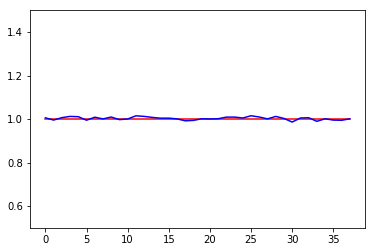

In [147]:
plot_prices(market, 'wavg_edge_bidask')

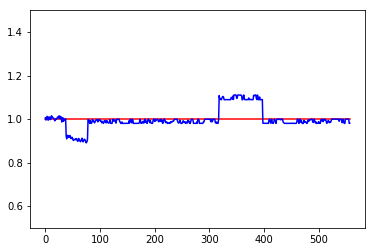

In [161]:
market.usd_eth = 0.01
NUM_ORDERS_LIVE = 100000
NUM_TRADERS = trader_demographics['RandomTrader'] # We initially set it up with randomTraders

offset = trader_demographics['IdealTrader']
for _ in range(NUM_ORDERS):
    tid = randint(offset + 1, offset + NUM_TRADERS)
    order = traderPool[tid].marketStep()
    if order: 
#         print (market.getCurrentUSDValue())
#         print (order)
        trades, idNum = market.processOrder(order)    
        
plot_prices(market, 'wavg_edge_bidask')

In [149]:
print (market.orderbook)

------ Bids -------
489.151522813	@	0.0099	t=3983
675	@	0.0099	t=3988
473	@	0.0099	t=3990
617	@	0.0099	t=3997
402.46514596	@	0.0098	t=1070
1283	@	0.0098	t=1073
954	@	0.0098	t=1089
963	@	0.0098	t=1092
1043	@	0.0098	t=1107
910	@	0.0098	t=1136
1150	@	0.0098	t=1150
991	@	0.0098	t=1162
1020	@	0.0098	t=1174
908	@	0.0098	t=1186
826	@	0.0098	t=1214
889	@	0.0098	t=1266
979	@	0.0098	t=1305
916	@	0.0098	t=1340
1112	@	0.0098	t=1349
1053	@	0.0098	t=1358
1026	@	0.0098	t=1380
1176	@	0.0098	t=1381
877	@	0.0098	t=1405
1020	@	0.0098	t=1460
1169	@	0.0098	t=1497
1023	@	0.0098	t=1514
991	@	0.0098	t=1523
1116	@	0.0098	t=1533
899	@	0.0098	t=1541
1311	@	0.0098	t=1548
986	@	0.0098	t=1550
1053	@	0.0098	t=1555
915	@	0.0098	t=1578
1132	@	0.0098	t=1587
994	@	0.0098	t=1600
900	@	0.0098	t=1601
1135	@	0.0098	t=1605
996	@	0.0098	t=1618
891	@	0.0098	t=1661
1148	@	0.0098	t=1681
1265	@	0.0098	t=1684
1127	@	0.0098	t=1691
977	@	0.0098	t=1698
907	@	0.0098	t=1704
1179	@	0.0098	t=1707
1052	@	0.0098	t=1717
1046	@	0.0098	t=1721

(array([  2.,   2.,   4.,   5.,  13.,  22.,  30.,  18.,   4.,   5.]),
 array([-107772.85356673,  -87014.71621005,  -66256.57885338,
         -45498.44149671,  -24740.30414004,   -3982.16678336,
          16775.97057331,   37534.10792998,   58292.24528665,
          79050.38264333,   99808.52      ]),
 <a list of 10 Patch objects>)

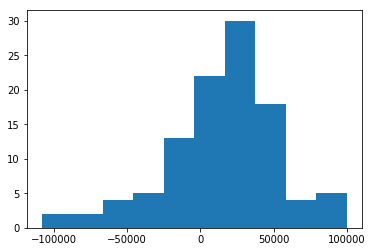

In [95]:
final_values = [trader.getIdealValue() for trader in traderPool.values()]
plt.hist(final_values, bins=10)

In [164]:
print (market.orderbook)

------ Bids -------
564.730839524	@	0.0099	t=27999
259.97833251	@	0.0098	t=25692
700	@	0.0098	t=25705
1497	@	0.0098	t=25728
513	@	0.0098	t=25732
269	@	0.0098	t=25756
1297	@	0.0098	t=25757
466	@	0.0098	t=25765
513	@	0.0098	t=25773
391	@	0.0098	t=25803
1430	@	0.0098	t=25811
1367	@	0.0098	t=25838
839	@	0.0098	t=25849
351	@	0.0098	t=25863
174	@	0.0098	t=25877
1980	@	0.0098	t=25881
158	@	0.0098	t=25896
2281	@	0.0098	t=25910
432	@	0.0098	t=25920
588	@	0.0098	t=25925
325	@	0.0098	t=25932
717	@	0.0098	t=25933
250	@	0.0098	t=25934
280	@	0.0098	t=25937
350	@	0.0098	t=25939
328	@	0.0098	t=25954
670	@	0.0098	t=25955
207	@	0.0098	t=25970
84	@	0.0098	t=25980
73	@	0.0098	t=25989
229	@	0.0098	t=25999
650	@	0.0098	t=26012
232	@	0.0098	t=26022
589	@	0.0098	t=26026
353	@	0.0098	t=26045
175	@	0.0098	t=26053
136	@	0.0098	t=26055
516	@	0.0098	t=26062
633	@	0.0098	t=26069
3212	@	0.0098	t=26080
480	@	0.0098	t=26105
651	@	0.0098	t=26107
209	@	0.0098	t=26108
131	@	0.0098	t=26120
390	@	0.0098	t=26123
497	@	0.009